In [1]:
import numpy as np
import scipy as sc
from typing import Optional

In [ ]:
def std_matrix(std: list) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract D matrix and D^-1 matrix from a list of variables. Used in Y to X or X to Y transformation.

    :param std: Standard deviation parameters.

    return: output[0] = D matrix, output[1] = D^-1 matrix
    """

    dneq = np.zeros((len(std), len(std)))
    dneq1 = np.zeros((len(std), len(std)))
    for i, sigma in enumerate(std):
        dneq[i, i] = sigma
        dneq1[i, i] = 1 / sigma

    return dneq, dneq1


def mu_matrix(mean: list) -> np.ndarray:
    """
    Extract mean matrix from a list of variables. Used in Y to X or X to Y transformation.

    :param mu: Mean parameters.

    return: Mean matrix
    """

    mu_neq = np.zeros((len(mean), 1))
    for i, mu in enumerate(mean):
        mu_neq[i, 0] = mu

    return mu_neq

def x_to_y(x: np.ndarray, dneq1: np.ndarray, mu_neq: np.ndarray) -> np.ndarray:
    """
    Transforms a vector of random variables from the X space to the Y space.

    :param x: Random variables in the X space.
    :param dneq1: D^-1 matrix.
    :param mu_neq: Mean matrix.

    :return: Transformed random variables in the Y space.
    """

    return dneq1 @ (x - mu_neq)


def y_to_x(y: np.ndarray, dneq: np.ndarray, mu_neq: np.ndarray) -> np.ndarray:
    """
    Transforms a vector of random variables from the Y space to the X space.

    :param y: Random variables in the Y space.
    :param dneq: D matrix.
    :param mu_neq: Mean matrix.

    :return: Transformed random variables in the X space.
    """

    return dneq @ y + mu_neq


def convert_params_to_scipy(dist: str, parameters: dict) -> dict:
    """
    Convert user-provided distribution parameters to the format required by "scipy.stats".

    :param parameters: Original distribution parameters.

    :return: Transformed parameters.
    """

    if dist.lower() == 'uniform':
        parameters_scipy = {'loc': parameters['min'], 'scale': parameters['max'] - parameters['min']}
    elif dist.lower() == 'normal':
        parameters_scipy = {'loc': parameters['mean'], 'scale': parameters['std']}
    elif dist.lower() == 'lognormal':
        epsilon = np.sqrt(np.log(1 + (parameters['std'] / parameters['mean'])**2))
        lambdaa = np.log(parameters['mean']) - 0.50 * epsilon**2
        # lognorm_dist = np.random.lognormal(lambdaa, epsilon, 100000)
        # s, l, sca = sc.stats.lognorm.fit(lognorm_dist)
        # parameters_scipy = {'s': s, 'loc': l, 'scale': sca}
        parameters_scipy = {'lambda': lambdaa, 'epsilon': epsilon}
    elif dist.lower() == 'gumbel max':
        euler_gamma = 0.5772156649015329
        alpha = parameters['std'] * np.sqrt(6) / np.pi
        beta = parameters['mean'] - alpha * euler_gamma
        parameters_scipy = {'loc': beta, 'scale': alpha}

    return parameters_scipy


def normal_tail_approximation(dist: str, parameters_scipy: dict, x: float) -> tuple[float, float]:
    """
    Converts non-normal distributions to normal approximations while preserving their statistical properties in x point.

    :param dist: Type of distribution. Supported values: 'uniform', 'normal', 'lognormal', 'gumbel max', 'gumbel min', 'triangular', 'gamma'.
    :param parameters_scipy: Distribution parameters according scipy.stats documentation.
    :param x: Project point.

    return: output[0] = Mean of the normal approximation at point x, output[1] = standard deviation of the normal approximation at point x.
    """

    if dist.lower() == 'uniform':
        loc = parameters_scipy['loc']
        scale = parameters_scipy['scale'] - parameters_scipy['loc']
        z_aux = sc.stats.uniform.cdf(x, loc=loc, scale=scale)
        z = sc.stats.norm.ppf(z_aux, loc=0, scale=1)
        num = sc.stats.norm.pdf(z, loc=0, scale=1)
        den = sc.stats.uniform.pdf(x, loc=loc, scale=scale)
        std_eq = num / den
        mean_eq = x - std_eq * z
    elif dist.lower() == 'normal':
        mean_eq = parameters_scipy['loc']
        std_eq = parameters_scipy['scale']
    elif dist.lower() == 'lognormal':
        epsilon = parameters_scipy['epsilon']
        lambdaa = parameters_scipy['lambda']
        # mean_eq = x * (1 - np.log(x) + lambdaa)
        # std_eq = x * epsilon
        # s = parameters_scipy['s']
        # loc = parameters_scipy['loc']
        # scale = parameters_scipy['scale']
        s = parameters_scipy['epsilon']
        loc = 0
        scale = np.exp(parameters_scipy['lambda'])
        z_aux = sc.stats.lognorm.cdf(x, s=s, loc=loc, scale=scale)
        z = sc.stats.norm.ppf(z_aux, loc=0, scale=1)
        num = sc.stats.norm.pdf(z, loc=0, scale=1)
        den = sc.stats.lognorm.pdf(x, s=s, loc=loc, scale=scale)
        std_eq = num / den
        mean_eq = x - std_eq * z
    elif dist.lower() == 'gumbel max':
        loc = parameters_scipy['loc']
        scale = parameters_scipy['scale']
        z_aux = sc.stats.gumbel_r.cdf(x, loc=loc, scale=scale)
        z = sc.stats.norm.ppf(z_aux, loc=0, scale=1)
        num = sc.stats.norm.pdf(z, loc=0, scale=1)
        den = sc.stats.gumbel_r.pdf(x, loc=loc, scale=scale)
        std_eq = num / den
        mean_eq = x - std_eq * z

    return mean_eq, std_eq


def obj(x):
    return x[0] * x[1] - 78.12 * x[2]


def deterministic_algorithm_structural_analysis_(n_iter: int, variables: list, x0: list, args: Optional[tuple] = None) -> tuple[float, float]:
    """
    """

    # Cornell index
    
    x_old_list = []
    beta_old_list = []
    y_old_list = []
    g_diff_y_list = []
    x_new_list = []
    y_new_list = []
    beta_new_list = []
    x = x0.copy()
    
    # Iteration process
    for i in range(n_iter):
        mu_eq = []
        sigma_eq = []

        # Convert variables in Normal pattern
        for i, var in enumerate(variables):
            mean = var['parameters']['mean']
            std = var['parameters']['std']
            # print('mean: ', mean)
            # print('std: ', std)
            paras_scipy = convert_params_to_scipy(var['type'], var['parameters'])
            m, s = normal_tail_approximation(var['type'], paras_scipy, x[i])
            # print("paras_scipy :", paras_scipy)
            # print("m: ", m)
            # print("s: ", s)
            mu_eq.append(m)
            sigma_eq.append(s)
        
        # yk
        print("mu: ", mu_eq)
        print("sigma: ", sigma_eq)
        dneq, dneq1 = std_matrix(sigma_eq)
        mu_vars = mu_matrix(mu_eq)
        y_old = x_to_y(np.array(x).reshape(-1, 1), dneq1, mu_vars)
        print("y_old: ", y_old)
        y_old_list.append(y_old)

        # Numerical differentiation g(x) and g(y)
        H = 1E-12
        g_diff_x_p = []
        g_diff_x_r = []
        for i in range(len(variables)):
            x_aux_p = x.copy()
            x_aux_p[i] += H
            x_aux_r = x.copy()
            x_aux_r[i] -= H
            g_diff_x_p.append(obj(x_aux_p))
            g_diff_x_r.append(obj(x_aux_r))
        g_diff_x = [(g_diff_x_p[i] - g_diff_x_r[i]) / (2 * H) for i in range(len(variables))]
        g_diff_y = np.matrix_transpose(dneq) @ np.array(g_diff_x).reshape(-1, 1)
        g_diff_y_neg = -1 * g_diff_y
        print('gdiffy: ' , g_diff_y)

        # Update y (HLRF algorithm)
        num = np.matrix_transpose(g_diff_y_neg) @ y_old
        norm = np.linalg.norm(g_diff_y_neg)
        beta = num / norm
        print("beta: ", beta)
        alpha = g_diff_y_neg / norm
        print("alpha: ", alpha)
        y = alpha @ beta
        x = y_to_x(y, dneq, mu_vars)
        x = x.flatten().tolist()
        print("ynew: ", y)
        print("xnew: ", x)

    return 0, 0

In [3]:
x = [2.4105, 1.1041, 1.3065]
# r = {'type': 'lognormal', 'parameters': {'mean': 3.3289, 'std': 0.4328}}
r = {'type': 'normal', 'parameters': {'mean': 3.3289, 'std': 0.4328}}
d = {'type': 'normal', 'parameters': {'mean': 1.0500, 'std': 0.1050}}
# l = {'type': 'gumbel max', 'parameters': {'mean': 1.0000, 'std': 0.2500}}
e = {'type': 'normal', 'parameters': {'mean': 2*1E7, 'std': 0.5*1E7}}
i = {'type': 'normal', 'parameters': {'mean': 1E-4, 'std': 0.2 * 1E-4}}
p = {'type': 'gumbel max', 'parameters': {'mean': 4., 'std': 1.}}
var = [e, i, p]
x = [2*1E7, 1E-4, 4.]

deterministic_algorithm_structural_analysis_(10, var, x)

mu:  [20000000.0, 0.0001, np.float64(3.830443842462364)]
sigma:  [5000000.0, 2e-05, np.float64(0.9561535427008898)]
y_old:  [[0.        ]
 [0.        ]
 [0.17733152]]
gdiffy:  [[  0.        ]
 [399.99999672]
 [-74.78702598]]
beta:  [[0.0325905]]
alpha:  [[-0.        ]
 [-0.98296685]
 [ 0.18378292]]
ynew:  [[ 0.        ]
 [-0.03203539]
 [ 0.00598958]]
xnew:  [20000000.0, 9.935929229527275e-05, 3.8361707987045928]
mu:  [20000000.0, 0.0001, np.float64(3.8357157034958744)]
sigma:  [5000000.0, 2e-05, np.float64(0.8976729230446735)]
y_old:  [[ 0.        ]
 [-0.03203539]
 [ 0.00050697]]
gdiffy:  [[  0.        ]
 [399.99999672]
 [-70.212874  ]]
beta:  [[0.03164062]]
alpha:  [[-0.        ]
 [-0.98494133]
 [ 0.17288891]]
ynew:  [[ 0.        ]
 [-0.03116416]
 [ 0.00547031]]
xnew:  [20000000.0, 9.937671681655051e-05, 3.8406262553548363]
mu:  [20000000.0, 0.0001, np.float64(3.835711000277354)]
sigma:  [5000000.0, 2e-05, np.float64(0.8992472519064323)]
y_old:  [[ 0.        ]
 [-0.03116416]
 [ 0.0054

(0, 0)

0.12946847734303465 1.1942608757781785


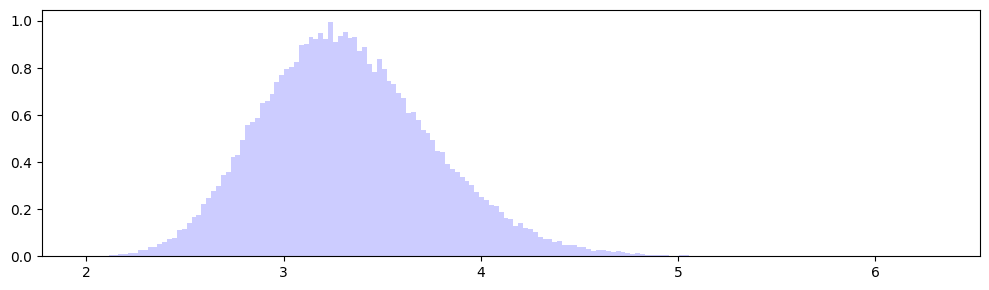

In [4]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

mu = 3.3289
sigma = 0.4328
n = 100000

epsilon = np.sqrt(np.log(sigma**2 / mu**2 + 1))
lambdaa = np.log(mu) - epsilon**2 / 2
print(epsilon, lambdaa)

lognorm_dist = np.random.lognormal(lambdaa, epsilon, n)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))  # figsize ajusta o tamanho
ax.hist(lognorm_dist, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color='blue')
plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import lognorm
s, l, sc = lognorm.fit(lognorm_dist)
print(s, l, sc)

0.13571085713145148 0.14312377846504987 3.1545256118039675
